<a href="https://colab.research.google.com/github/danielnrocha/HackathonAgroSenar/blob/main/Previs%C3%A3o_do_Pre%C3%A7o_de_Commodities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição do Preço de Commodities
## Union Squad
Os dados foram coletados do seguinte site: https://www.cepea.esalq.usp.br/

Dados do leite em dólar foram consultados em: https://br.investing.com/commodities/class-iii-milk-futures

In [2]:
%%capture 
%pip install quandl 
%pip install jupyterthemes

In [1]:
# %%capture 
%pip install plotly==4.14.0

In [3]:
import quandl 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [4]:
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [5]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)

import matplotlib.style
import matplotlib as mpl
for m,n in zip(['grid.color','axes.titlecolor','axes.labelcolor','xtick.color','ytick.color','axes.titlesize',
    'figure.figsize','legend.framealpha'],['white','white','white','white','white','20.0','13.0, 8.0','0.8']):
    mpl.rcParams[m] = n

In [6]:
milho = pd.read_excel('milho-esalq.xlsx')
milho["À vista R$"] = [float('.'.join(i.split(','))) for i in milho["À vista R$"]]
milho["À vista US$"] = [float('.'.join(i.split(','))) for i in milho["À vista US$"]]
milho.drop(index=[0,len(milho)-1,len(milho)-2],inplace=True)
milho.reset_index(inplace=True,drop=True)
milho.Data = pd.to_datetime(milho.Data)

In [7]:
soja = pd.read_excel('soja-esalq.xlsx')
soja["À vista R$"] = [float('.'.join(i.split(','))) for i in soja["À vista R$"]]
soja["À vista US$"] = [float('.'.join(i.split(','))) for i in soja["À vista US$"]]
soja.drop(index=[len(soja)-1,len(soja)-2],inplace=True)
soja.Data = pd.to_datetime(soja.Data)

In [8]:
arroz = pd.read_excel('arroz-esalq.xlsx')
arroz["À vista R$"] = [1.2*float('.'.join(i.split(','))) for i in arroz["À vista R$"]]
arroz["À vista US$"] = [1.2*float('.'.join(i.split(','))) for i in arroz["À vista US$"]]
arroz.drop(index=[len(arroz)-1,len(arroz)-2],inplace=True)
arroz.Data = pd.to_datetime(arroz.Data)

In [9]:
pecuaria = pd.read_excel('pecuaria-esalq.xlsx')
pecuaria.Data = pd.to_datetime(pecuaria.Data).values.astype('datetime64[M]')
pecuaria = pecuaria.groupby('Data',as_index=False).mean().copy()
pecuaria['À vista R$'] = pecuaria['À vista R$']/2.5
pecuaria['À vista US$'] = pecuaria['À vista US$']/2.5

In [10]:
trigo = pd.read_excel('trigo-esalq.xlsx')
trigo["À vista R$"] = [0.06*float('.'.join(''.join(i.split('.')).split(','))) for i in trigo["À vista R$"]]
trigo["À vista US$"] = [0.06*float('.'.join(''.join(i.split('.')).split(','))) for i in trigo["À vista US$"]]
trigo.drop(index=[len(trigo)-1,len(trigo)-2],inplace=True)
trigo.Data = pd.to_datetime(trigo.Data)

In [11]:
leite = pd.read_excel('leite-esalq-old.xlsx')
leite["Preço Real"] = [60*float('.'.join(i.split(','))) for i in leite['Preço Real']]
leite.Data = pd.to_datetime(leite.Data)
leite.columns = ["Data","À vista R$","À vista US$"]

In [12]:
ipca = quandl.get(["BCB/433"], start_date="2004-07-01", collapse='monthly', api_key='dQfS4ReMWX3wuUxGRnVR')
ipca.index = milho.Data
ipca.columns = ["IPCA"]
ipca.reset_index(inplace=True)

In [13]:
usa_inflation = quandl.get(["RATEINF/INFLATION_USA"], start_date="2004-07-01", collapse='monthly', api_key='dQfS4ReMWX3wuUxGRnVR')
usa_inflation.index = milho.Data
usa_inflation.columns = ["USA_INFLATION"]
usa_inflation.reset_index(inplace=True)

In [14]:
for i in ['milho','soja','arroz','pecuaria','trigo','leite']:
    globals()[i] = globals()[i].merge(ipca[ipca.Data>=globals()[i]['Data'][0]]).copy()
    globals()[i]["Deflacionado_BR"] = globals()[i]['À vista R$']/(1 + globals()[i]["IPCA"]/100)

In [15]:
for i in ['milho','soja','arroz','pecuaria','trigo','leite']:
    globals()[i] = globals()[i].merge(usa_inflation[usa_inflation.Data>=globals()[i]['Data'][0]]).copy()
    globals()[i]["Deflacionado_US"] = globals()[i]['À vista US$']/(1 + globals()[i]["USA_INFLATION"]/100)

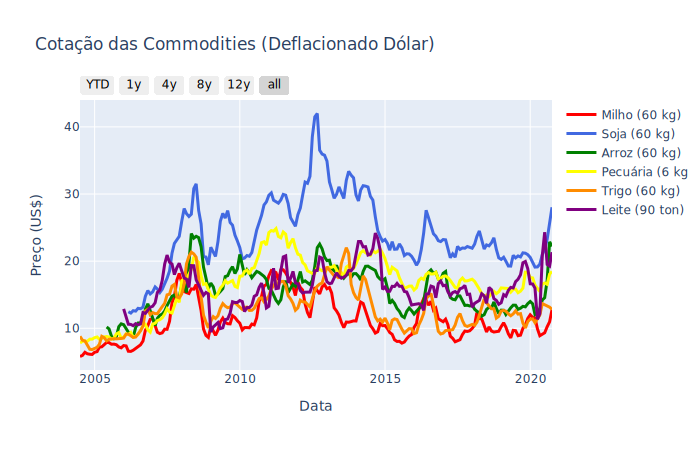

In [16]:
import plotly.graph_objects as go

# Initialize figure
fig = go.Figure()

# Add Traces
fig.add_trace(go.Scatter(x=milho.Data, y=milho.Deflacionado_US,
                    line=dict(color='red', width=3), name='Milho (60 kg)'))
fig.add_trace(go.Scatter(x=soja.Data, y=soja.Deflacionado_US,
                    line=dict(color='royalblue', width=3), name='Soja (60 kg)'))
fig.add_trace(go.Scatter(x=arroz.Data, y=arroz.Deflacionado_US,
                    line=dict(color='green', width=3), name='Arroz (60 kg)'))
fig.add_trace(go.Scatter(x=pecuaria.Data, y=pecuaria.Deflacionado_US,
                    line=dict(color='yellow', width=3), name='Pecuária (6 kg)'))
fig.add_trace(go.Scatter(x=trigo.Data, y=trigo.Deflacionado_US,
                    line=dict(color='darkorange', width=3), name='Trigo (60 kg)'))
fig.add_trace(go.Scatter(x=leite.Data, y=leite.Deflacionado_US,
                    line=dict(color='purple', width=3), name='Leite (90 ton)'))

# Edit the layout
fig.update_layout(title='Cotação das Commodities (Deflacionado Dólar)',
                   xaxis_title='Data', yaxis_title='Preço (US$)',
                   )#template='plotly_dark')

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(count=8,
                     label="8y",
                     step="year",
                     stepmode="backward"),
                dict(count=12,
                     label="12y",
                     step="year",
                     stepmode="backward"),
                dict(step="all"),
            ])
        ),
        
        type="date"
    )
)

fig.update_xaxes(rangeselector_font_color='black')

# fig.show()
fig.show('svg');

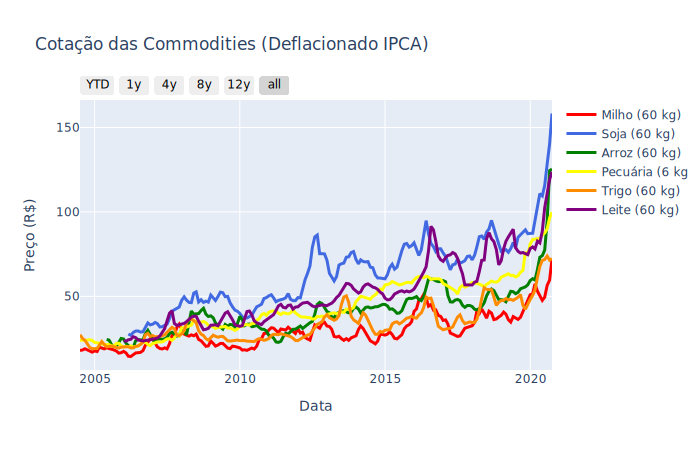

In [18]:
import plotly.graph_objects as go

# Initialize figure
fig = go.Figure()

# Add Traces
fig.add_trace(go.Scatter(x=milho.Data, y=milho.Deflacionado_BR,
                    line=dict(color='red', width=3), name='Milho (60 kg)'))
fig.add_trace(go.Scatter(x=soja.Data, y=soja.Deflacionado_BR,
                    line=dict(color='royalblue', width=3), name='Soja (60 kg)'))
fig.add_trace(go.Scatter(x=arroz.Data, y=arroz.Deflacionado_BR,
                    line=dict(color='green', width=3), name='Arroz (60 kg)'))
fig.add_trace(go.Scatter(x=pecuaria.Data, y=pecuaria.Deflacionado_BR,
                    line=dict(color='yellow', width=3), name='Pecuária (6 kg)'))
fig.add_trace(go.Scatter(x=trigo.Data, y=trigo.Deflacionado_BR,
                    line=dict(color='darkorange', width=3), name='Trigo (60 kg)'))
fig.add_trace(go.Scatter(x=leite.Data, y=leite.Deflacionado_BR,
                    line=dict(color='purple', width=3), name='Leite (60 kg)'))

# Edit the layout
fig.update_layout(title='Cotação das Commodities (Deflacionado IPCA)',
                   xaxis_title='Data', yaxis_title='Preço (R$)',
                   )#template='plotly_dark')

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(count=8,
                     label="8y",
                     step="year",
                     stepmode="backward"),
                dict(count=12,
                     label="12y",
                     step="year",
                     stepmode="backward"),
                dict(step="all"),
            ])
        ),
        
        type="date"
    )
)

fig.update_xaxes(rangeselector_font_color='black')

# fig.show()
fig.show('svg');